In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [68]:
def add_bar(fig, freqs, measures_lst, colors_base, label_lst, ylabels=None):
    colors_lst = [colors_base * (1 + i*0.5) for i in range(len(measures_lst))]
    x = np.arange(len(freqs))
    plt.rcParams['axes.grid'] = True
    for i, (measures, colors, label) in enumerate(zip(measures_lst, colors_lst, label_lst)):
        gap = .8/len(measures_lst)
        for num, measure in enumerate(measures.keys()):
            ax = fig.add_subplot(int(round(len(measures.keys()))/3)+1, 3, num + 1)
            freqs_bar = [str(f) for f in freqs]
            ax.bar(x + i * gap, np.array(measures[measure], dtype='float'), color = colors[num], width = gap, label=label)
            ax.set_title((measure.upper()).replace('_', ' '), fontsize=25)
            ax.legend()
            plt.xlabel('Hz', fontsize=15)
            if ylabels is not None:
                plt.ylabel(ylabels[num], fontsize=15, rotation=0, labelpad=25)
            ax.set_xticklabels(freqs)
            plt.grid()
    plt.tight_layout()
    return int(round(len(measures.keys()))), 3

In [69]:
def read_measures_freqs(dataset_base_path, tracking_type=None, separator='_'):
    
    csvs_names = os.listdir(dataset_base_path)
    tracks_dir = [csv for csv in csvs_names if csv.endswith('.csv')]
    if tracking_type is not None:
        tracks_dir = [name for name in csvs_names if tracking_type in name.split(separator)]

    measures = {
        'vcl': [],
        'vsl': [],
        'vap_mean': [],
        'alh_mean': [],
        'lin': [],
        'wob': [],
        'str': [],
        'bcf_mean': [],
        'mad': [],
        'fluo': []
    }
    
    ylabels = [r'$\frac{\mu m}{s}$', r'$\frac{\mu m}{s}$', r'$\frac{\mu m}{s}$', 
              r'$\mu m$', '', '', '', 'Hz', r'$\mu m$', 'mgv']
    
    freqs = []
    for freq in tracks_dir:
        fps = (freq.split('Hz'))[0].split(separator)[-1]
        freqs.append(fps)
        full_path_file = os.path.join(dataset_base_path, freq)
        freq_df = pd.read_csv(full_path_file)
        for measure in list(measures.keys()):
            measures[measure].append(freq_df[measure].mean())
    freqs = np.array(freqs, dtype='int')
    order = np.argsort(freqs)
    for m in measures.keys():
        measures[m] = [measures[m][o] for o in order]
    return np.sort(freqs), measures, ylabels

In [81]:
indir_ds = 'measures_tracking'
indir_gt = 'measures_on_gt'
datasets = ['dataset_{}'.format(i) for i in range(1, 6)]

os.makedirs('out_figs', exist_ok=True)
for dataset in datasets:
    gt_path = os.path.join(indir_gt, dataset)
    ds_path = os.path.join(indir_ds, dataset)
    fig = plt.figure(figsize=(20, 15))
    freqs, measures_ds, ylabels = read_measures_freqs(ds_path, tracking_type='ennjpdaf')
    _, measures_gt, _ = read_measures_freqs(gt_path, separator='(')
    colors = np.random.uniform(0.1,0.4, (len(list(measures_gt.keys())), 3))
    add_bar(fig=fig, freqs=freqs, measures_lst=(measures_gt, measures_ds),
            colors_base=colors, label_lst=('ground truth', 'ennjpdaf'), ylabels=ylabels)
    fig.suptitle(dataset.upper().replace('_', ' '), fontsize=32, y=1.015)
    plt.tight_layout
    plt.savefig('out_figs/{}.png'.format(dataset), bbox_inches='tight')
    plt.close()

<ipython-input-68-c3b0e07485e8>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(int(round(len(measures.keys()))/3)+1, 3, num + 1)


In [129]:
def mse(freqs, measures_gt, measures_ds):
    mse ={}
    for i, freq in enumerate(freqs):
        mse[freq] = {}
        for measure in measures_gt:
            mse[freq][measure] = np.mean((measures_gt[measure][i] - measures_ds[measure][i])**2)
    return mse

def relative_error(freqs, measures_gt, measures_ds):
    relative_error ={}
    for measure in measures_gt:
        relative_error[measure] = []
        for i, freq in enumerate(freqs):
            relative_error[measure].append(np.round(np.mean((measures_gt[measure][i] - measures_ds[measure][i])/measures_gt[measure][i])*100))
    return relative_error

In [131]:
indir_ds = 'measures_tracking'
indir_gt = 'measures_on_gt'
datasets = ['dataset_{}'.format(i) for i in range(1, 6)]

os.makedirs('out_figs', exist_ok=True)
errors_dataset = {}
for dataset in datasets:
    gt_path = os.path.join(indir_gt, dataset)
    ds_path = os.path.join(indir_ds, dataset)
    freqs, measures_ds, ylabels = read_measures_freqs(ds_path, tracking_type='ennjpdaf')
    for i, freq in enumerate(freqs):
        errors_dataset[dataset] = relative_error(freqs, measures_gt, measures_ds)

In [126]:
mean_error_datasets ={} 
for dataset in datasets:
    for measure in errors_dataset[dataset][measure]:
        mean_error_datasets[measure] = 
        mean_error_datasets[measure].append(np.mean(errors_dataset[dataset][measure]))

In [132]:
mean_error_datasets.keys()

dict_keys(['vcl', 'vsl', 'vap_mean', 'alh_mean', 'lin', 'wob', 'str', 'bcf_mean', 'mad', 'fluo'])

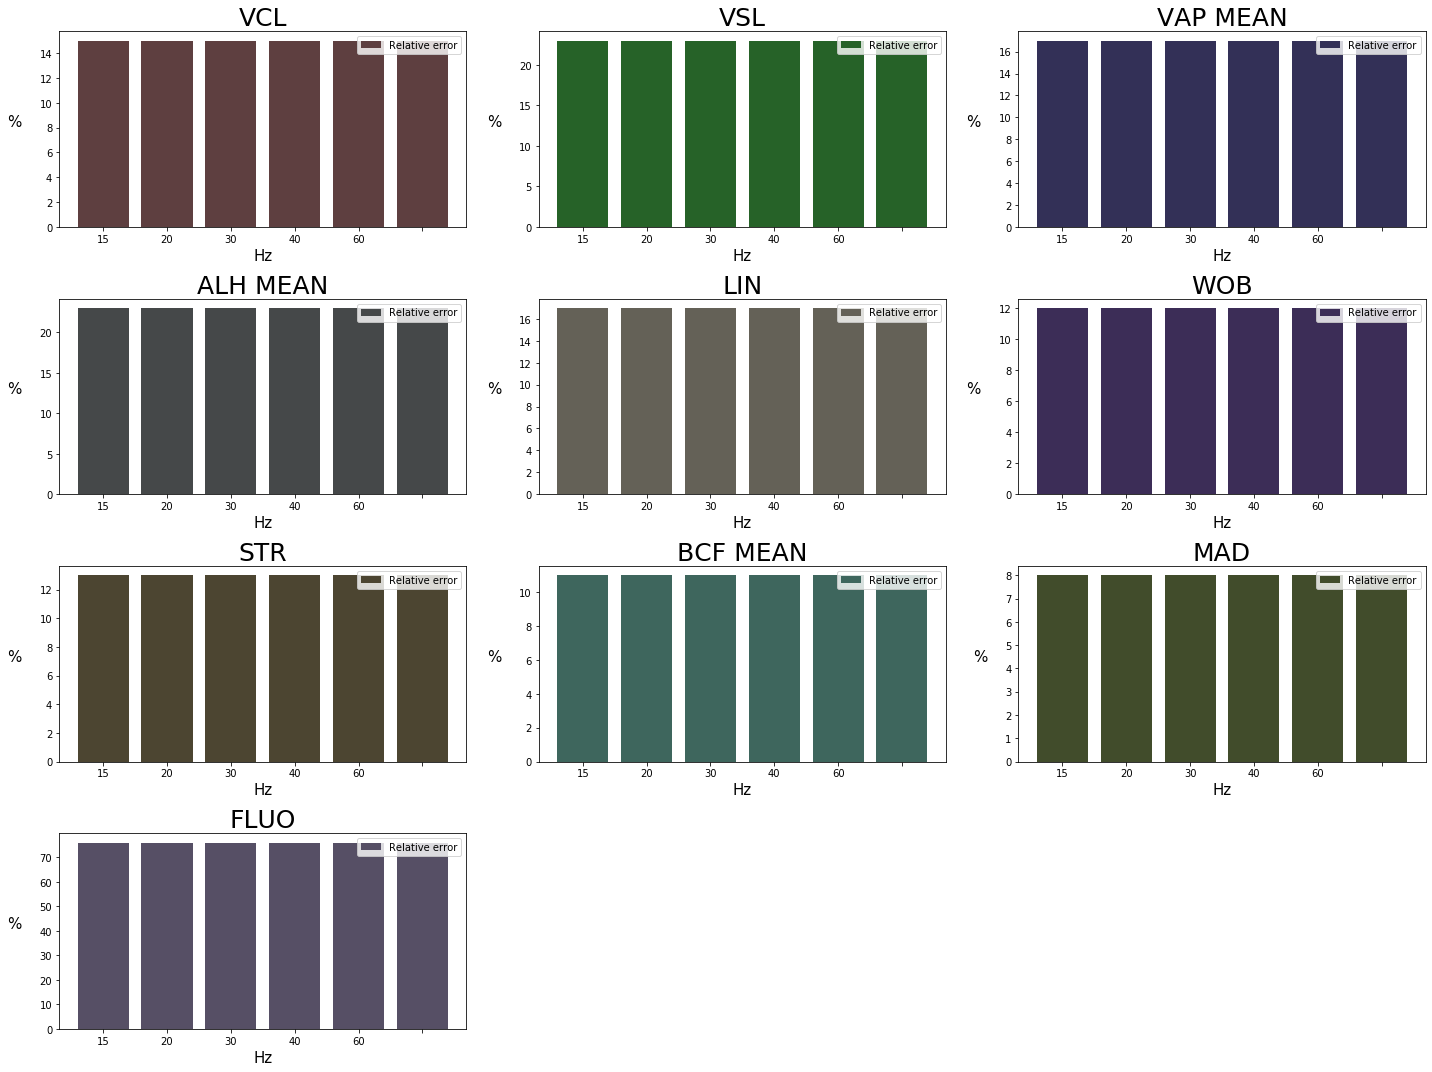

In [134]:
fig = plt.figure(figsize=(20, 15))
colors = np.random.uniform(0.1,0.4, (len(list(mean_error_datasets.keys())), 3))
add_bar(fig=fig, freqs=freqs, measures_lst=list([mean_error_datasets]),
            colors_base=colors, label_lst=list(['Relative error']), ylabels=['%' for i in range(len(ylabels))])
plt.tight_layout
plt.show()
